# Seq2Seq
- Encoder: encodes the source sentence into a *single vector* -> **context vector** (*abstract representation of the input sentence*).
- Decoder: learns to *generate the output sentence* given the context vector, one word at a time

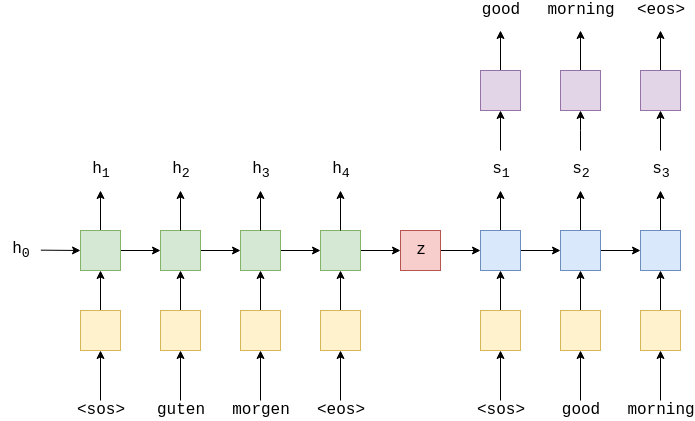
- The input sentence is passed through the **Embedding** layer before going through the **RNN**.
- Each RNN has 2 inputs:
 1. The embeddings of the current word
 2. The hidden state of the previous layer h<sub>t-1</sub>
- And outputs: a new hidden state h<sub>t</sub>
- *h<sub>i</sub>* (hidden state) -> the vector representation of the sentence
----------------------
- h<sub>0</sub> of **Encoder** -> initialized to 0 or a learned parameter
- h<sub>0</sub> of **Decoder** -> initialized to Z (the final decoder hidden state)
-------------------------
#### Teacher Forcing 
- While training: sometimes using the ground truth next word in the sequence y<sub>t</sub> and sometimes use the word predicted by our decoder y_pred<sub>t-1</sub>

# Preparing Data 

In [2]:
# !pip install torchtext==0.5
# !python -m spacy download en
# !python -m spacy download de

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

In [5]:
# loading spacy models
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [6]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1] # reverse the order of the input to increase many short term dependencies (from paper)

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [7]:
SRC = Field(tokenize=tokenize_de,
           init_token='<sos>',
           eos_token='<eos>',
           lower=True)

TRG = Field(tokenize=tokenize_en,
           init_token='<sos>',
           eos_token='<eos>',
           lower=True)

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                   fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 537kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 166kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 158kB/s]


In [9]:
# checking the right number of data is loaded
print(f"# of training examples: {len(train_data.examples)}")
print(f"# of validation examples: {len(valid_data.examples)}")
print(f"# of testin examples: {len(test_data.examples)}")

# of training examples: 29000
# of validation examples: 1014
# of testin examples: 1000


In [10]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [36]:
# building the vocab only from training (avoid data leaking)
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [37]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7854
Unique tokens in target (en) vocabulary: 5893


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Bucket iterators
- Adds the padding to sequences 
- Tries to minimize the amount of padding by rearranging the sequences

In [17]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
(train_data, valid_data, test_data),
batch_size=BATCH_SIZE,
device=device)

## The models 

### Encoder 

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        #src = [src len, batch_size]
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        return hidden, cell

### Decoder 
- outputs a single token per time step

In [66]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size] sequence length = 1
        #hidden = [n layers * n directions, batch size, hid dim]
        #n directions in the decoder and encoder will both always be 1 therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, threfore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        predictions = self.fc_out(output.squeeze(0))
        return predictions, hidden, cell

In [67]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # storing decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)
        
        # last hidden state of the decoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to decoder <sos>
        input = trg[0, :]
        
        for t in range(1, trg_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1)
            
            input = trg[t] if teacher_force else top1
        
        return outputs

In [77]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [78]:
# initializing weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7854, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [79]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,898,757 trainable parameters


In [80]:
optimizer = optim.Adam(model.parameters())

In [81]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [82]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss=0
    for i, batch in enumerate(iterator):
        
        src=batch.src
        trg=batch.trg
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        # flatten before crossentropy
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss/len(iterator)

In [83]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0 
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            
            output = model(src, trg, 0) # turn off teacher forcing
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss/len(iterator)

In [84]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [85]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 36s
	Train Loss: 5.072 | Train PPL: 159.515
	 Val. Loss: 5.044 |  Val. PPL: 155.025
Epoch: 02 | Time: 0m 36s
	Train Loss: 4.538 | Train PPL:  93.481
	 Val. Loss: 4.961 |  Val. PPL: 142.792
Epoch: 03 | Time: 0m 36s
	Train Loss: 4.222 | Train PPL:  68.160
	 Val. Loss: 4.567 |  Val. PPL:  96.222
Epoch: 04 | Time: 0m 36s
	Train Loss: 3.982 | Train PPL:  53.601
	 Val. Loss: 4.483 |  Val. PPL:  88.456
Epoch: 05 | Time: 0m 35s
	Train Loss: 3.814 | Train PPL:  45.334
	 Val. Loss: 4.347 |  Val. PPL:  77.271
Epoch: 06 | Time: 0m 36s
	Train Loss: 3.655 | Train PPL:  38.674
	 Val. Loss: 4.355 |  Val. PPL:  77.839
Epoch: 07 | Time: 0m 36s
	Train Loss: 3.510 | Train PPL:  33.435
	 Val. Loss: 4.062 |  Val. PPL:  58.076
Epoch: 08 | Time: 0m 36s
	Train Loss: 3.368 | Train PPL:  29.035
	 Val. Loss: 3.972 |  Val. PPL:  53.079
Epoch: 09 | Time: 0m 36s
	Train Loss: 3.237 | Train PPL:  25.449
	 Val. Loss: 3.925 |  Val. PPL:  50.673
Epoch: 10 | Time: 0m 36s
	Train Loss: 3.136 | Train PPL

In [86]:
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.867 | Test PPL:  47.811 |
